__Project:__ Text Classification <br> 
__Sub-prj:__ Parametric Evaluation - _number of labels & data instances_ <br>
__Experm:__ Distilbert-base-uncased <br>
__Status:__ Version 2.6 <br>
    - Reconfigured for instance level sampling <br>
    - Compilation is set out of loop <br>
    - Full experiment is run <br>
    - Results Visualized <br>

Amir Hossini

#### Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import transformers
from transformers import AutoTokenizer
from transformers import TFAutoModelForSequenceClassification
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import Callback
import sklearn
from sklearn.metrics import confusion_matrix,f1_score,precision_score,recall_score 
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

print(f"Tensorflow version: {tf.__version__}")
print(f"Sklearn version: {sklearn.__version__}")
print(f"Transformers version: {transformers.__version__}")

physical_devices = tf.config.list_physical_devices('GPU') 
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)
    
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow version: 2.7.0
Sklearn version: 0.24.2
Transformers version: 4.13.0
Num GPUs Available:  1


#### I/O Files & Params

In [2]:
fl_train        = '../datasets/banking77/train.csv'
fl_test         = '../datasets/banking77/test.csv'

checkpoint      ='distilbert-base-uncased'

experiment_grid = {
    'n_labels'  : [64],
    'n_train_inst': [16]
}

seed = 42
BIG_int = 10**21

#### Functions

In [3]:
class Metrics(Callback):
    def __init__(self, validation_data):
        super(Metrics, self).__init__()
        self.validation_data = validation_data
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(tf.nn.softmax(self.model.predict(self.validation_data[0]).logits),1)
        val_targ = self.validation_data[1]
        val_f1 = f1_score(val_targ, val_predict, average='macro')
        val_recall = recall_score(val_targ, val_predict, average='macro')
        val_precision = precision_score(val_targ, val_predict, average='macro')
        logs['val_f1'] = val_f1
        logs['val_recall'] = val_recall
        logs['val_precision'] = val_precision
        print (f'— val_f1: {round(val_f1,4)} — val_precision: {round(val_precision,4)} — val_recall: {round(val_recall,4)}')
        return

def select_data_instances(train, test, col_label, n_labels=None, n_train_inst=None):
    if n_labels is None:
        n_labels = len(train.loc[:,col_label].unique())
    if n_train_inst is None:
        n_train_inst = BIG_int 
        
    select_labels = np.array(train.loc[:,col_label].value_counts()[0:n_labels].index)
    select_train  = train.loc[train[col_label].isin(select_labels),:].reset_index(drop=True)
    subset_train  = pd.DataFrame(columns=select_train.columns)
    for label in select_labels:
        temp_train   = select_train.loc[select_train[col_label]==label,:].reset_index(drop=True)
        select_indx  = np.random.choice(range(len(temp_train)),min(n_train_inst,len(temp_train)))
        temp_train   = temp_train.iloc[select_indx,:]
        subset_train = subset_train.append(temp_train)
    subset_train = subset_train.sample(frac=1).reset_index(drop=True)
    select_test  = test.loc[test[col_label].isin(select_labels),:].reset_index(drop=True)
    select_test  = select_test.sample(frac=1).reset_index(drop=True)
    return subset_train, select_test 

def factorize_data(train, test, col_label,return_keys=False):
    train_labels, levels = pd.factorize(train.loc[:,col_label])
    categs = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().index
    labels = pd.concat([train.loc[:,col_label],pd.Series(train_labels)],axis=1).groupby(col_label).mean().values.T[0]
    label_keys=dict(zip(categs,labels))
    test_labels = test.loc[:,col_label].map(lambda x: label_keys[x])
    train.loc[:,col_label]=train_labels
    test.loc[:,col_label]=test_labels
    if return_keys:
        return train, test, label_keys
    else:
        return train, test
    
def tokenize_encode_data(train,test,col_text,col_label,checkpoint,
                         truncation_flag=True, padding_flag=True, return_tensors_opt='np'):
    train_sentences = list(train.loc[:,col_text])
    test_sentences  = list(test.loc[:,col_text])
    train_labels    = list(train.loc[:,col_label])
    test_labels     = list(test.loc[:,col_label])
    tokenizer       = AutoTokenizer.from_pretrained(checkpoint)
    train_encodings = tokenizer(train_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    test_encodings  = tokenizer(test_sentences, truncation=truncation_flag,
                                padding=padding_flag, return_tensors=return_tensors_opt)
    return train_encodings.data, train_labels, test_encodings.data, test_labels 

def transformer_model_compile(checkpoint,n_labels,lr=5e-5):
    model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=n_labels)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
    return model

def transformer_model_fit(model, train_encodings, train_labels, test_encodings, test_labels,epochs=10,batch_size=64):
    history = model.fit(train_encodings,np.array(train_labels),epochs=epochs,batch_size=batch_size,
          validation_data=(test_encodings, np.array(test_labels)),callbacks=[Metrics(validation_data)])
    return history, model

def make_plots(df):  
    sns.set_style("whitegrid")
    sns.set(rc={'figure.figsize':(10,6)})
    sns.set_context("talk")
    sns.lineplot(x="sample_size", y="val_f1", hue="num_categ", marker='o', data=df, legend="full")
    plt.show()
    sns.lineplot(hue="sample_size", y="val_f1", x="num_categ", marker='o', data=df, legend="full")

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_transform', 'activation_13', 'vocab_projector', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'dropout_19', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i


Experiment 1 with 64 labels and 16 instances

size of training dataset: 1024
size of testing dataset: 2560


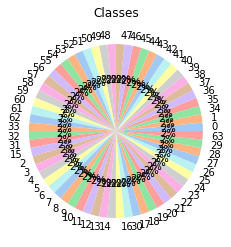

Epoch 1/50
16/16 [==============================] - 21s 1s/step - loss: 4.1430 - accuracy: 0.0273 - val_loss: 4.0583 - val_accuracy: 0.0727 - val_f1: 0.0458 - val_recall: 0.0727 - val_precision: 0.1571
Epoch 2/50
16/16 [==============================] - 15s 958ms/step - loss: 3.9432 - accuracy: 0.2500 - val_loss: 3.7799 - val_accuracy: 0.4301 - val_f1: 0.3866 - val_recall: 0.4301 - val_precision: 0.5415
Epoch 3/50
16/16 [==============================] - 15s 1s/step - loss: 3.6076 - accuracy: 0.5293 - val_loss: 3.4112 - val_accuracy: 0.5570 - val_f1: 0.5166 - val_recall: 0.5570 - val_precision: 0.6240
Epoch 4/50
16/16 [==============================] - 15s 961ms/step - loss: 3.1981 - accuracy: 0.6660 - val_loss: 3.0054 - val_accuracy: 0.6430 - val_f1: 0.6129 - val_recall: 0.6430 - val_precision: 0.7124
Epoch 5/50
16/16 [==============================] - 15s 968ms/step - loss: 2.7619 - accuracy: 0.7744 - val_loss: 2.5927 - val_accuracy: 0.7012 - val_f1: 0.6825 - val_recall: 0.7012 - val

Epoch 24/50
16/16 [==============================] - 16s 1s/step - loss: 0.0525 - accuracy: 1.0000 - val_loss: 0.6179 - val_accuracy: 0.8371 - val_f1: 0.8367 - val_recall: 0.8371 - val_precision: 0.8432
Epoch 25/50
16/16 [==============================] - 15s 1s/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 0.6190 - val_accuracy: 0.8336 - val_f1: 0.8332 - val_recall: 0.8336 - val_precision: 0.8400
Epoch 26/50
16/16 [==============================] - 16s 1s/step - loss: 0.0441 - accuracy: 1.0000 - val_loss: 0.6187 - val_accuracy: 0.8371 - val_f1: 0.8367 - val_recall: 0.8371 - val_precision: 0.8435
Epoch 27/50
16/16 [==============================] - 16s 1s/step - loss: 0.0402 - accuracy: 1.0000 - val_loss: 0.6181 - val_accuracy: 0.8355 - val_f1: 0.8350 - val_recall: 0.8355 - val_precision: 0.8419
Epoch 28/50
16/16 [==============================] - 15s 1s/step - loss: 0.0367 - accuracy: 1.0000 - val_loss: 0.6177 - val_accuracy: 0.8359 - val_f1: 0.8358 - val_recall: 0.8359 - val_pre

Epoch 48/50
16/16 [==============================] - 15s 993ms/step - loss: 0.0120 - accuracy: 1.0000 - val_loss: 0.6444 - val_accuracy: 0.8367 - val_f1: 0.8363 - val_recall: 0.8367 - val_precision: 0.8431
Epoch 49/50
16/16 [==============================] - 15s 991ms/step - loss: 0.0115 - accuracy: 1.0000 - val_loss: 0.6547 - val_accuracy: 0.8379 - val_f1: 0.8375 - val_recall: 0.8379 - val_precision: 0.8450
Epoch 50/50
16/16 [==============================] - 15s 991ms/step - loss: 0.0111 - accuracy: 1.0000 - val_loss: 0.6513 - val_accuracy: 0.8371 - val_f1: 0.8367 - val_recall: 0.8371 - val_precision: 0.8439


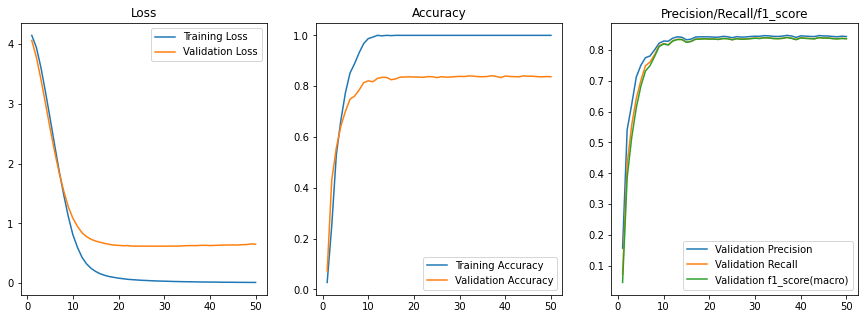

In [4]:
np.random.seed(seed)
train_orig = pd.read_csv(fl_train)
test_orig  = pd.read_csv(fl_test)

Big_Matrix      = pd.DataFrame(columns=['num_categ','sample_size','val_f1'])

iexp=0
for ilab in experiment_grid['n_labels']:
    compiled_model = transformer_model_compile(checkpoint,ilab)
    for i_ninst in experiment_grid['n_train_inst']:
        iexp+=1
        train, test = select_data_instances(train_orig, test_orig, 'category', ilab, i_ninst)
        train, test = factorize_data(train, test, 'category')
        print(f'\nExperiment {iexp} with {ilab} labels and {i_ninst} instances')
        print(f'\nsize of training dataset: {len(train)}')
        print(f'size of testing dataset: {len(test)}')
        colors = sns.color_palette('pastel')[0:ilab]
        _ = plt.pie(list(train['category'].value_counts()), 
                    labels = list(train['category'].value_counts().index), 
                    colors = colors, autopct='%.0f%%')
        _ = plt.title('Classes')
        _ = plt.show()
        
        train_encodings, train_labels, test_encodings, test_labels = tokenize_encode_data(train,test,'text',
                                                                                          'category',checkpoint)
        validation_data                                            =(test_encodings, np.array(test_labels))
        
        history, fitted_model = transformer_model_fit(compiled_model,train_encodings,train_labels,
                                                      test_encodings, test_labels,epochs=50)

        fig, axes   = plt.subplots(1,3,figsize=(15,5))
        epoch_range = np.arange(1,len(history.history['loss'])+1)
        axes[0]   = sns.lineplot(ax=axes[0],x=epoch_range,y=history.history['loss'],label='Training Loss')
        axes[0]   = sns.lineplot(ax=axes[0],x=epoch_range,y=history.history['val_loss'],label='Validation Loss').set_title('Loss')
        axes[1]   = sns.lineplot(ax=axes[1],x=epoch_range,y=history.history['accuracy'],label='Training Accuracy')
        axes[1]   = sns.lineplot(ax=axes[1],x=epoch_range,y=history.history['val_accuracy'],label='Validation Accuracy').set_title('Accuracy')
        axes[2]   = sns.lineplot(ax=axes[2],x=epoch_range,y=history.history['val_precision'],label='Validation Precision')
        axes[2]   = sns.lineplot(ax=axes[2],x=epoch_range,y=history.history['val_recall'],label='Validation Recall')
        axes[2]   = sns.lineplot(ax=axes[2],x=epoch_range,y=history.history['val_f1'],label='Validation f1_score(macro)').set_title('Precision/Recall/f1_score')
        axes[1].set_ylim=(0, 1)
        axes[2].set_ylim=(0, 1)
        _         = plt.show()
        
        Big_Matrix.loc[iexp,'num_categ']    = ilab
        Big_Matrix.loc[iexp,'sample_size']  = i_ninst
        Big_Matrix.loc[iexp,'val_f1'] = np.max(history.history['val_f1'])

In [5]:
Big_Matrix.to_csv('DistilBERT_Big_Matrix64.csv',index=False)

#### Data Load & Visualize

In [ ]:
Big_Matrix=pd.read_csv('DistilBERT_Big_Matrix64.csv.csv')

In [ ]:
display(Big_Matrix.pivot(index='num_categ', columns='sample_size', values='val_f1'))
make_plots(Big_Matrix)